In [1]:
import random
import numpy as np
import tensorflow as tf
import os

# Set seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
import pandas as pd
import numpy as np
import os

meta = pd.read_csv('Train_Test_Split.csv')
meta = meta[meta['label'].isin(['AD', 'Healthy'])]

train_meta = meta[meta['split'] == 'train']
test_meta = meta[meta['split'] == 'test']

def load_and_segment(subject_id, data_dir='Data_sampled_128HZ', segment_len=1024):
    file_path = os.path.join(data_dir, f"{subject_id}_data.npy")
    data = np.load(file_path)
    _, time_steps = data.shape
    num_segments = time_steps // segment_len
    if num_segments == 0:
        return np.empty((0, 19, segment_len))
    data = data[:, :num_segments * segment_len]
    segments = data.reshape(19, num_segments, segment_len).transpose(1, 0, 2)
    return segments

def process_data(meta_df, data_dir='Data_sampled_128HZ'):
    X = []
    y = []
    label_map = {'AD': 1, 'Healthy': 0}
    for _, row in meta_df.iterrows():
        segments = load_and_segment(row['subject_id'], data_dir)
        if segments.shape[0] == 0:
            continue
        X.append(segments)
        label = label_map[row['label']]
        one_hot = np.eye(2)[label]
        y.extend([one_hot] * segments.shape[0])
    X = np.concatenate(X, axis=0)
    y = np.array(y)
    return X, y
X_train, y_train = process_data(train_meta)
X_test, y_test = process_data(test_meta)
X_train = (X_train * 1e6) - np.mean(X_train * 1e6, axis=2, keepdims=True)
X_test = (X_test * 1e6) - np.mean(X_test * 1e6, axis=2, keepdims=True)

In [3]:
from tensorflow.keras.models import load_model, Model

def load_and_trim_model(path):
    model = load_model(path)
    model.pop() 
    model.trainable = False  # freeze
    return model
bilstm_model = load_and_trim_model('Models\Final_Bilstm_model.keras')
cnn_time_model = load_and_trim_model('Models\Final_CNNSpatial_model.keras')
cnn_freq_model = load_and_trim_model('Models\Final_CNNSpectral_model.keras')

Preparing training data inputs...

--- Starting Experiment 3: Ablation Study ---
Pre-calculating training features...
164/164 ━━━━━━━━━━━━━━━━━━━━ 47s 286ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

RUNNING EXPERIMENT: Full (B+T+F)

Training model with 3 input(s)...
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - AUC: 0.9775 - accuracy: 0.9468 - loss: 0.1702 - val_AUC: 0.9780 - val_accuracy: 0.9371 - val_loss: 0.1998 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - AUC: 0.9983 - accuracy: 0.9887 - loss: 0.0354 - val_AUC: 0.9718 - val_accuracy: 0.9238 - val_loss: 0.2338 - learning_rate: 0.0010
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - AUC: 0.9976 - accuracy: 0.9904 - loss: 0.0323 - val_AUC: 0.9663 - val_accuracy: 0.9133 - val_loss: 0.2732 - learning_rate: 0.0010
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - AUC: 0.9977 - accuracy: 0.9894 - loss: 0.0385 - val_AUC: 0.9856 - val_accu

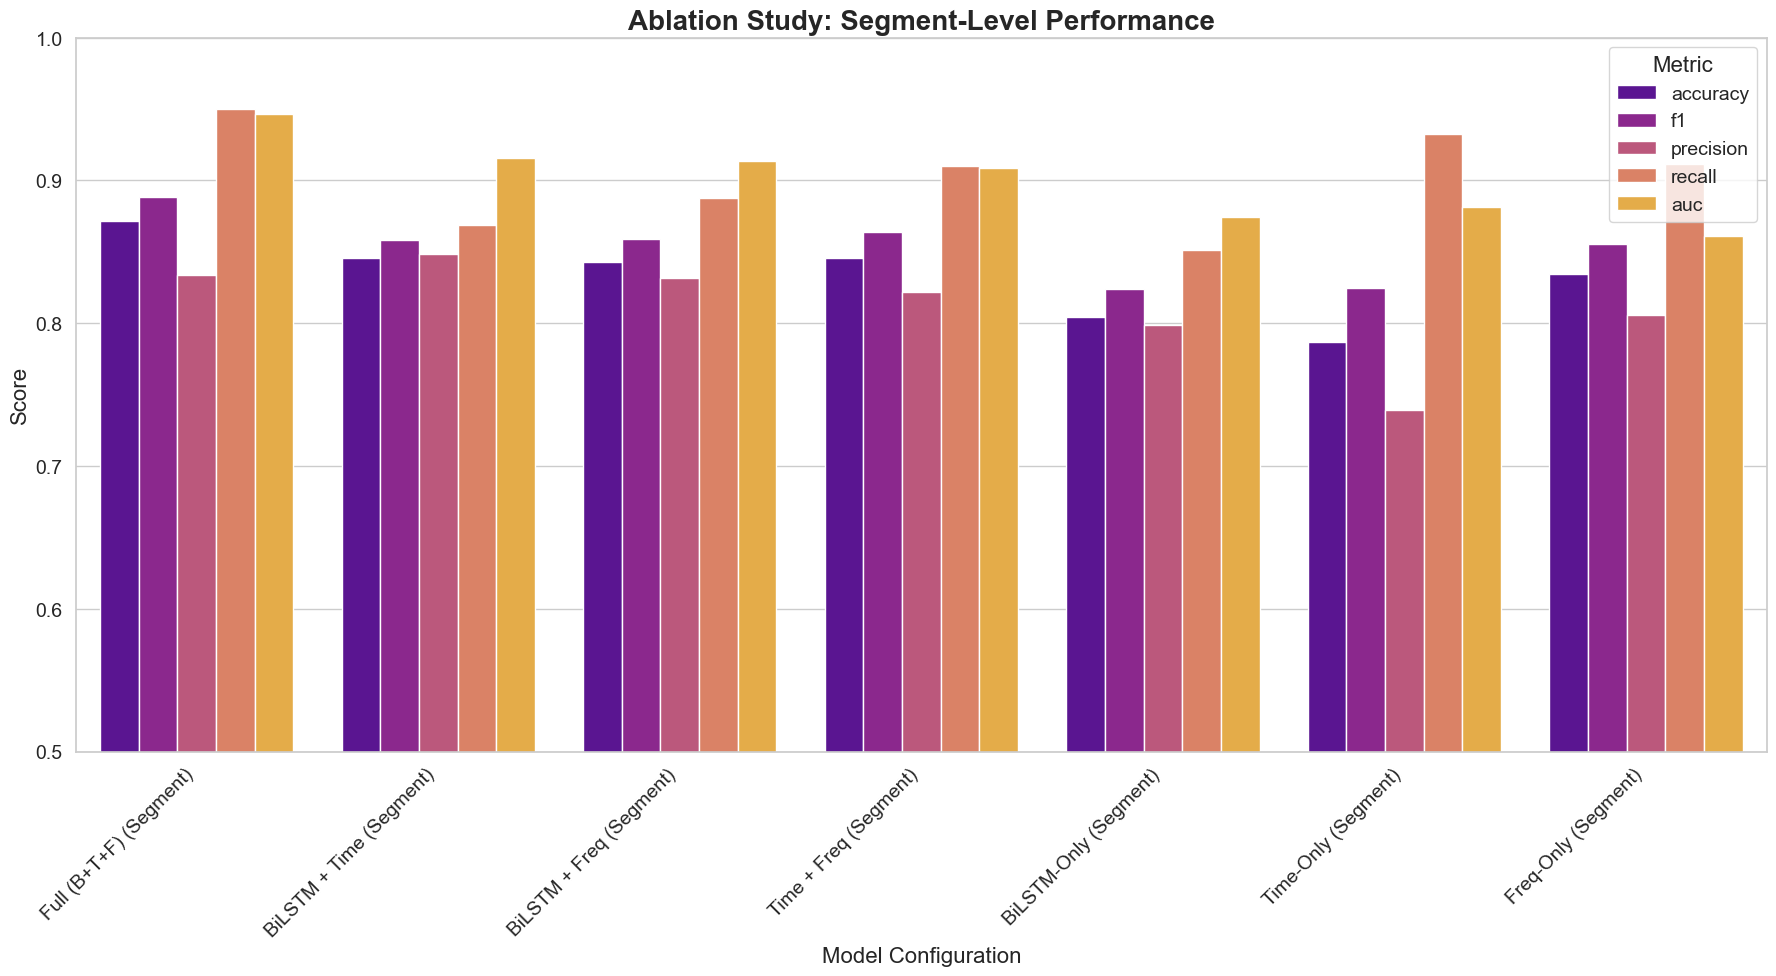

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Concatenate, Lambda, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.signal import welch
from scipy.stats import mode
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. NEW MODEL BUILDER (from Step 1) ---
def build_fusion_model_ablation(
    bilstm_shape, cnn_time_shape, cnn_freq_shape,
    use_bilstm=True, use_cnn_time=True, use_cnn_freq=True,
    common_dim=128, num_heads=4, ff_dim=256, dropout_rate=0.3, num_transformer_blocks=2
):
    """
    Builds the fusion model with optional input branches for ablation study.
    """
    
    model_inputs = []
    projections = []

    if use_bilstm:
        bilstm_input = Input(shape=bilstm_shape[1:], name="bilstm_input")
        model_inputs.append(bilstm_input)
        bilstm_proj = Dense(common_dim, name="bilstm_proj")(bilstm_input)
        projections.append(bilstm_proj)

    if use_cnn_time:
        cnn_time_input = Input(shape=cnn_time_shape[1:], name="cnn_time_input")
        model_inputs.append(cnn_time_input)
        cnn_time_proj = Dense(common_dim, name="cnn_time_proj")(cnn_time_input)
        projections.append(cnn_time_proj)

    if use_cnn_freq:
        cnn_freq_input = Input(shape=cnn_freq_shape[1:], name="cnn_freq_input")
        model_inputs.append(cnn_freq_input)
        cnn_freq_proj = Dense(common_dim, name="cnn_freq_proj")(cnn_freq_input)
        projections.append(cnn_freq_proj)

    if not projections:
        raise ValueError("Must use at least one input branch.")

    if len(projections) == 1:
        x = Lambda(lambda t: tf.expand_dims(t, axis=1))(projections[0])
    else:
        x = Lambda(lambda t: tf.stack(t, axis=1))(projections)

    for _ in range(num_transformer_blocks):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=common_dim)(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(ff_dim, activation='relu')(x)
        ffn_output = Dense(common_dim)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inputs=model_inputs, outputs=out)
    return model

# --- 2. MISSING FUNCTION (Added back) ---
def compute_spectral_features(X, fs=128, nperseg=256):
    num_segments, num_channels, num_samples = X.shape
    psd_all = []

    for seg in X:
        seg_psd = []
        for ch in seg:
            freqs, psd = welch(ch, fs=fs, nperseg=nperseg)
            seg_psd.append(psd)
        psd_all.append(seg_psd)

    psd_all = np.array(psd_all)  
    psd_all = np.log1p(psd_all)  
    return psd_all, freqs

# --- 3. NEW EVALUATION FUNCTION (from Step 2 - Moved here) ---
def patient_level_evaluation(
    fusion_model, 
    bilstm_base_model, cnn_time_base_model, cnn_freq_base_model, 
    meta_df, 
    use_bilstm=True, use_cnn_time=True, use_cnn_freq=True,
    voting='soft'
):
    """
    Performs patient-level evaluation for a specific model configuration.
    """
    
    # Patient-level accumulators
    y_true_patient = []
    y_pred_patient = []
    y_prob_patient = [] 

    # --- NEW: Segment-level accumulators ---
    all_segment_preds_list = []
    all_segment_true_labels_list = []
    # --- End NEW ---

    for _, row in meta_df.iterrows():
        subject_id = row['subject_id']
        label_str = row['label']
        true_label = 1 if label_str == 'AD' else 0

        segments = load_and_segment(subject_id)
        if segments.shape[0] == 0:
            continue
        segments = (segments * 1e6) - np.mean(segments * 1e6, axis=2, keepdims=True)
        
        model_input_features = []

        if use_bilstm:
            top_channels = [14, 2, 0, 18, 4]
            bilstm_input_data = segments[:, top_channels, :].transpose(0, 2, 1)
            bilstm_feat = bilstm_base_model.predict(bilstm_input_data, verbose=1)
            model_input_features.append(bilstm_feat)

        if use_cnn_time:
            cnn_time_input_data = segments[..., np.newaxis]
            cnn_time_feat = cnn_time_base_model.predict(cnn_time_input_data, verbose=1)
            model_input_features.append(cnn_time_feat)

        if use_cnn_freq:
            spec_feats, _ = compute_spectral_features(segments)
            cnn_freq_input_data = spec_feats[..., np.newaxis]
            cnn_freq_feat = cnn_freq_base_model.predict(cnn_freq_input_data, verbose=1)
            model_input_features.append(cnn_freq_feat)
        
        preds = fusion_model.predict(model_input_features, verbose=1)

        # --- NEW: Accumulate segment-level results ---
        all_segment_preds_list.append(preds)
        true_label_one_hot = np.eye(2)[true_label]
        segment_true_labels = np.array([true_label_one_hot] * segments.shape[0])
        all_segment_true_labels_list.append(segment_true_labels)
        # --- End NEW ---

        # Perform patient-level voting
        if voting == 'soft':
            avg_prob = np.mean(preds, axis=0)
            y_pred_patient.append(np.argmax(avg_prob))
            y_prob_patient.append(avg_prob[1]) # Probability of class '1' (AD)
        elif voting == 'hard':
            pred_classes = np.argmax(preds, axis=1)
            voted_class = mode(pred_classes, keepdims=True).mode[0]
            y_pred_patient.append(voted_class)
            y_prob_patient.append(np.mean(preds[:, 1])) 

        y_true_patient.append(true_label)
    
    # --- Process Patient-Level Metrics ---
    y_true_patient = np.array(y_true_patient)
    y_pred_patient = np.array(y_pred_patient)
    y_prob_patient = np.array(y_prob_patient)
    
    patient_metrics = {
        'accuracy': accuracy_score(y_true_patient, y_pred_patient),
        'f1': f1_score(y_true_patient, y_pred_patient, zero_division=0),
        'precision': precision_score(y_true_patient, y_pred_patient, zero_division=0),
        'recall': recall_score(y_true_patient, y_pred_patient, zero_division=0),
        'auc': roc_auc_score(y_true_patient, y_prob_patient)
    }
    
    print(f"--- Results for {voting} voting (Patient-Level) ---")
    print(classification_report(y_true_patient, y_pred_patient, zero_division=0))
    
    # --- NEW: Process Segment-Level Metrics ---
    all_segment_preds = np.concatenate(all_segment_preds_list, axis=0)
    all_segment_true_labels = np.concatenate(all_segment_true_labels_list, axis=0)
    
    segment_y_pred_classes = np.argmax(all_segment_preds, axis=1)
    segment_y_true_classes = np.argmax(all_segment_true_labels, axis=1)
    segment_y_prob_positive = all_segment_preds[:, 1]

    segment_metrics = {
        'accuracy': accuracy_score(segment_y_true_classes, segment_y_pred_classes),
        'f1': f1_score(segment_y_true_classes, segment_y_pred_classes, zero_division=0),
        'precision': precision_score(segment_y_true_classes, segment_y_pred_classes, zero_division=0),
        'recall': recall_score(segment_y_true_classes, segment_y_pred_classes, zero_division=0),
        'auc': roc_auc_score(segment_y_true_classes, segment_y_prob_positive)
    }
    
    # Bundle segment results for optional reporting
    segment_results_bundle = {
        'metrics': segment_metrics,
        'y_true': segment_y_true_classes,
        'y_pred': segment_y_pred_classes
    }
    # --- End NEW ---

    return patient_metrics, segment_results_bundle # MODIFIED return

# --- 4. MISSING DATA PREP (Added back) ---
print("Preparing training data inputs...")
#BiLSTM Inputs
top_channels = [14, 2, 0, 18, 4]
X_bilstm_input = X_train[:, top_channels, :].transpose(0, 2, 1)  # (samples, 1024, 5)

# CNNSPatial Inputs
X_cnn_time_input = X_train[..., np.newaxis]  # shape: (N, 19, 1024, 1)

#CNNSpectral Inputs
X_train_spec, freqs = compute_spectral_features(X_train)
X_cnn_freq_input = X_train_spec[..., np.newaxis]  # shape: (N, 19, freq_bins, 1)


# --- 5. MAIN ABLATION STUDY SCRIPT (from Step 3) ---
print("\n--- Starting Experiment 3: Ablation Study ---")

# --- 1. Define all 7 experiment configurations ---
# --- MODIFIED: Run all 7 models ---
experiments = [
    {'name': 'Full (B+T+F)', 'use_bilstm': True, 'use_cnn_time': True, 'use_cnn_freq': True},
    {'name': 'BiLSTM + Time', 'use_bilstm': True, 'use_cnn_time': True, 'use_cnn_freq': False},
    {'name': 'BiLSTM + Freq', 'use_bilstm': True, 'use_cnn_time': False, 'use_cnn_freq': True},
    {'name': 'Time + Freq', 'use_bilstm': False, 'use_cnn_time': True, 'use_cnn_freq': True},
    {'name': 'BiLSTM-Only', 'use_bilstm': True, 'use_cnn_time': False, 'use_cnn_freq': False},
    {'name': 'Time-Only', 'use_bilstm': False, 'use_cnn_time': True, 'use_cnn_freq': False},
    {'name': 'Freq-Only', 'use_bilstm': False, 'use_cnn_time': False, 'use_cnn_freq': True},
]
# --- End MODIFICATION ---

# --- 2. Pre-calculate all features for Training ---
print("Pre-calculating training features...")
X_bilstm_feat_train = bilstm_model.predict(X_bilstm_input)
X_cnn_time_feat_train = cnn_time_model.predict(X_cnn_time_input)
X_cnn_freq_feat_train = cnn_freq_model.predict(X_cnn_freq_input)

all_train_features = {
    'bilstm': X_bilstm_feat_train,
    'cnn_time': X_cnn_time_feat_train,
    'cnn_freq': X_cnn_freq_feat_train
}

bilstm_shape = bilstm_model.output_shape
cnn_time_shape = cnn_time_model.output_shape
cnn_freq_shape = cnn_freq_model.output_shape

# --- 3. Run the main experiment loop ---
final_results = []
final_segment_results = [] # --- NEW: List for segment results ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
]

for exp in experiments:
    print(f"\n=========================================")
    print(f"RUNNING EXPERIMENT: {exp['name']}")
    print(f"=========================================")

    fusion_model_abl = build_fusion_model_ablation(
        bilstm_shape, cnn_time_shape, cnn_freq_shape,
        use_bilstm=exp['use_bilstm'], 
        use_cnn_time=exp['use_cnn_time'], 
        use_cnn_freq=exp['use_cnn_freq'],
        common_dim=128, num_heads=4, ff_dim=256, dropout_rate=0.3, num_transformer_blocks=2
    )

    optimizer = Adam(learning_rate=1e-3)
    fusion_model_abl.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy','AUC'])

    X_train_list = []
    if exp['use_bilstm']:
        X_train_list.append(all_train_features['bilstm'])
    if exp['use_cnn_time']:
        X_train_list.append(all_train_features['cnn_time'])
    if exp['use_cnn_freq']:
        X_train_list.append(all_train_features['cnn_freq'])
    
    print(f"Training model with {len(X_train_list)} input(s)...")
    fusion_model_abl.fit(
        X_train_list,
        y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        verbose=1 # Set to 1 for epoch-level progress
    )
    print("Training complete.")

    print(f"Evaluating patient-level performance for: {exp['name']}")
    # --- MODIFIED: Capture both patient and segment metrics ---
    patient_metrics, segment_results = patient_level_evaluation(
        fusion_model_abl,
        bilstm_model, cnn_time_model, cnn_freq_model,
        test_meta, 
        use_bilstm=exp['use_bilstm'], 
        use_cnn_time=exp['use_cnn_time'], 
        use_cnn_freq=exp['use_cnn_freq'],
        voting='soft'
    )
    
    # --- RE-ENABLED: Patient metric storage ---
    patient_metrics['model'] = exp['name']
    final_results.append(patient_metrics)

    # --- MODIFIED: Always capture segment-level results ---
    print(f"--- Results for Segment-Level ({exp['name']}) ---")
    print(classification_report(segment_results['y_true'], segment_results['y_pred'], zero_division=0))
    
    segment_metrics_dict = segment_results['metrics']
    segment_metrics_dict['model'] = f"{exp['name']} (Segment)" # Add (Segment) to distinguish
    final_segment_results.append(segment_metrics_dict)
    # --- End MODIFICATION ---

# --- 4. Store and display final results ---
# --- RE-ENABLED: Patient-level results processing ---
df_results = pd.DataFrame(final_results)
df_results = df_results.set_index('model')
print("\n\n--- FINAL PATIENT-LEVEL RESULTS ---")
print(df_results)

df_results.to_csv("ablation_study_patient_results.csv")
print("Ablation study patient-level results saved to 'ablation_study_patient_results.csv'")
# --- End RE-ENABLED ---

# --- Store and display segment-level results (Now the primary output) ---
if final_segment_results:
    df_segment_results = pd.DataFrame(final_segment_results).set_index('model')
    print("\n\n--- SEGMENT-LEVEL RESULTS (for requested models) ---")
    print(df_segment_results)
    df_segment_results.to_csv("ablation_study_segment_results.csv")
    print("Segment-level results saved to 'ablation_study_segment_results.csv'")
# --- End NEW ---

# --- 5. Plot the final results ---
# --- REPLACED: This section now plots the SEGMENT-LEVEL results ---
print("Generating segment-level results plot...")

if final_segment_results:
    # Get the DataFrame we just created
    df_segment_plot = pd.DataFrame(final_segment_results).set_index('model')

    # --- MODIFIED: Define the order for all 7 models ---
    segment_model_order = [
        'Full (B+T+F) (Segment)',
        'BiLSTM + Time (Segment)',
        'BiLSTM + Freq (Segment)',
        'Time + Freq (Segment)',
        'BiLSTM-Only (Segment)',
        'Time-Only (Segment)',
        'Freq-Only (Segment)'
    ]
    # --- End MODIFICATION ---
    
    # Use .loc[...].reindex(...) to handle potential missing models
    df_segment_plot = df_segment_plot.loc[df_segment_plot.index.isin(segment_model_order)].reindex(segment_model_order)

    # "Melt" the DataFrame for easier plotting with seaborn
    df_segment_plot_melted = df_segment_plot.reset_index().melt(id_vars='model', var_name='Metric', value_name='Score')

    # Create the grouped bar chart
    plt.figure(figsize=(18, 10))
    sns.set(style="whitegrid", font_scale=1.2)
    sns.barplot(
        x='model', 
        y='Score', 
        hue='Metric', 
        data=df_segment_plot_melted,
        palette='plasma' # Changed palette for variety
    )

    plt.title('Ablation Study: Segment-Level Performance', fontsize=20, fontweight='bold')
    plt.xlabel('Model Configuration', fontsize=16)
    plt.ylabel('Score', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title='Metric', fontsize=14, title_fontsize=16, loc='upper right')
    plt.ylim(0.5, 1.0) # Zoom in on the 50-100% score range
    plt.tight_layout()

    # Save the plot
    plt.savefig("ablation_study_segment_results.png", dpi=300)
    print("Ablation study segment-level plot saved as 'ablation_study_segment_results.png'")

print("--- Experiment 3 (Expanded) Complete ---")
# --- End REPLACED ---